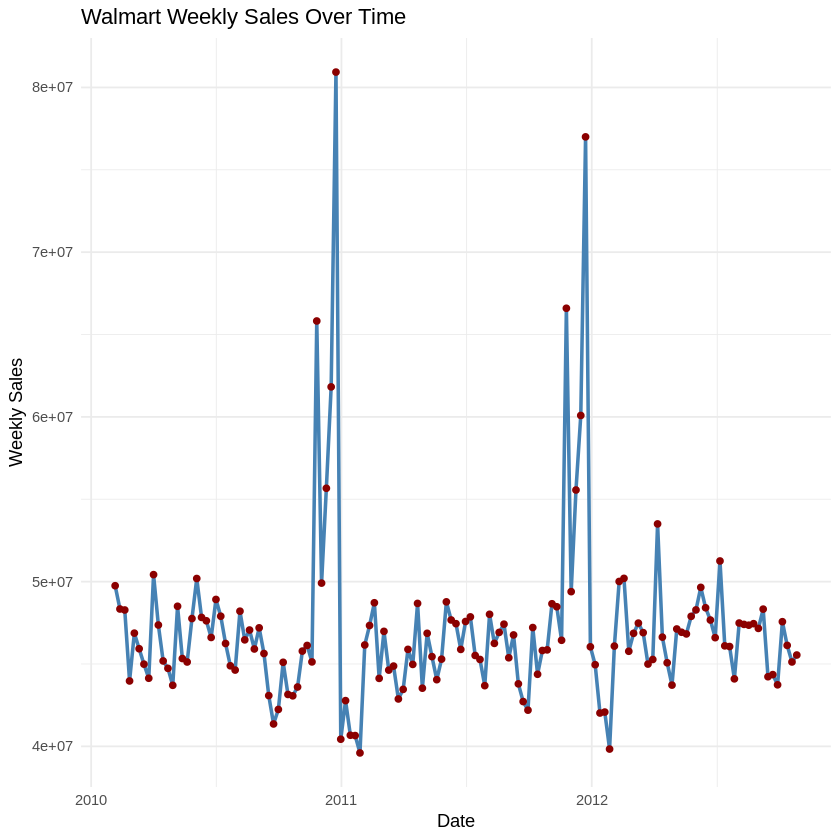

In [ ]:
library(readxl)
library(ggplot2)

# Load and prepare data
data <- read_excel("walmart_sales_cleaned.xlsx")
data$Date <- as.Date(data$Date, format = "%d-%m-%Y")
data_ts <- aggregate(Weekly_Sales ~ Date, data, sum)


# Plot with line + scatter points
ggplot(data_ts, aes(x = Date, y = Weekly_Sales)) +
  geom_line(color = "steelblue", size = 1) +
  geom_point(color = "darkred", size = 1.5) +
  ggtitle("Walmart Weekly Sales Over Time") +
  xlab("Date") +
  ylab("Weekly Sales") +
  theme_minimal()


**Stationarity Test (ADF Test)**

In [ ]:
install.packages("tseries")
library(tseries)

# Convert to time series object
sales_ts <- ts(data_ts$Weekly_Sales, frequency = 52)

# ADF test
adf.test(sales_ts)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message in adf.test(sales_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  sales_ts
Dickey-Fuller = -5.3039, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


**ACF and PACF for (p, q) Selection**

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’




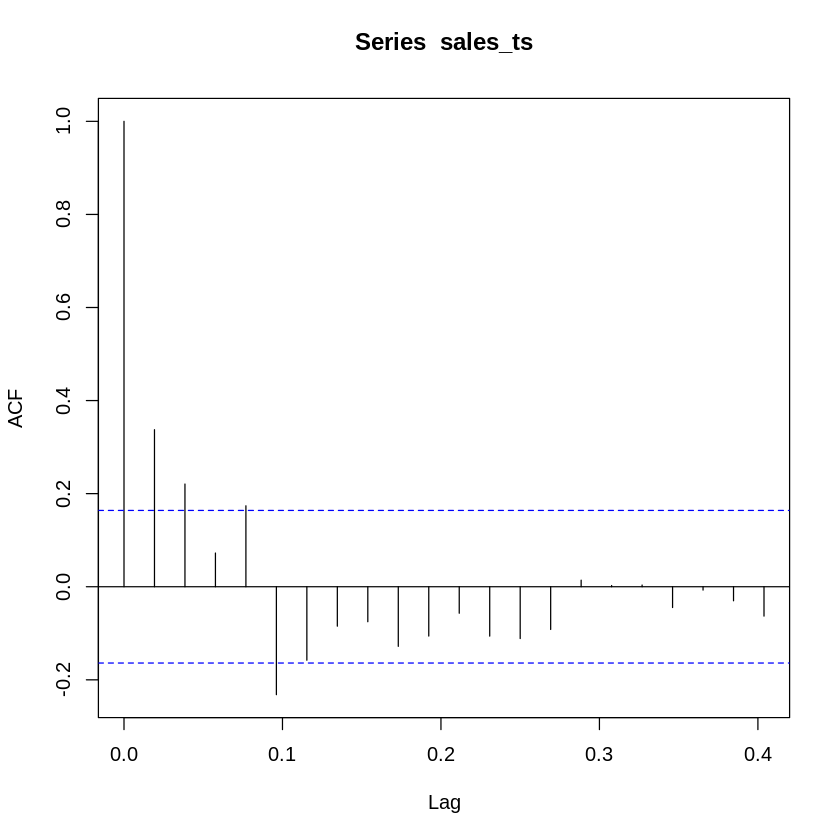

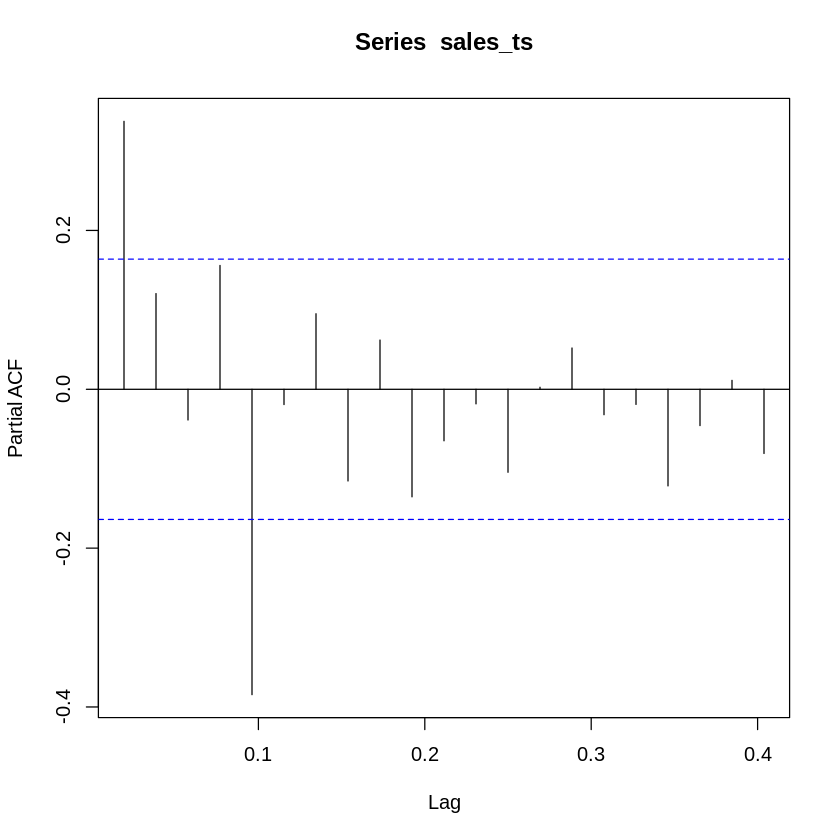

In [ ]:
install.packages("forecast")
library(forecast)

# ACF and PACF plots
acf(sales_ts)
pacf(sales_ts)



**Fit the ARIMA Model (1,1,1)**

[1] 4800.892

[1] 4809.759


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)
Q* = 37.901, df = 27, p-value = 0.07945

Model df: 2.   Total lags used: 29



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,51962.02,5106421,2755140,-0.7579671,5.435438,1.922709,-0.04781672


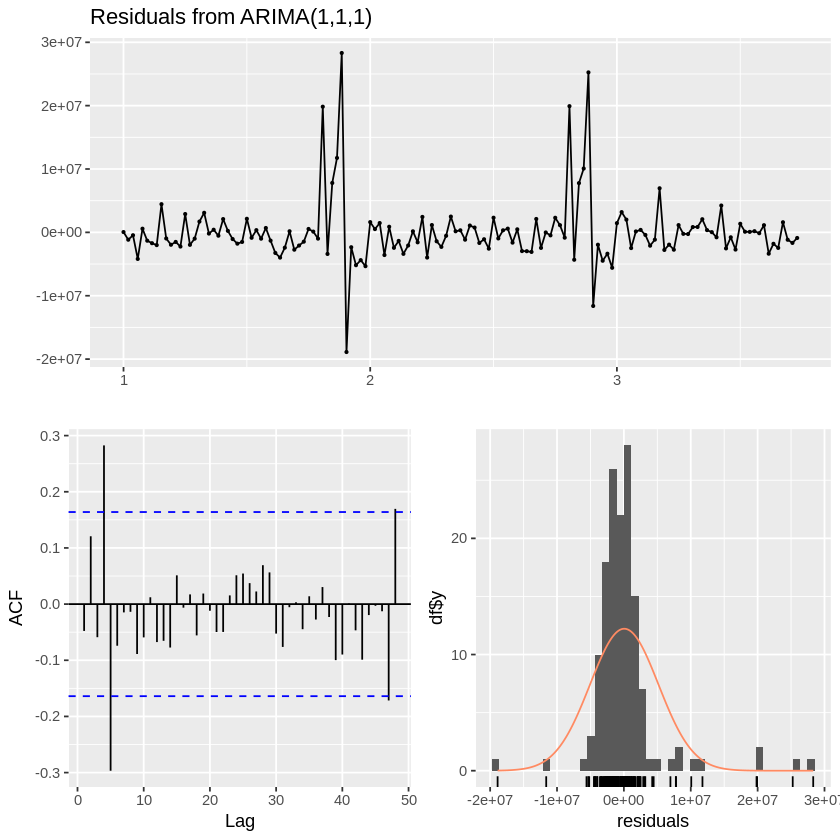

In [ ]:
# Fit both models
model_111 <- Arima(sales_ts, order = c(1,1,1))

# Compare AIC/BIC
AIC(model_111)
BIC(model_111)

# Check residuals
checkresiduals(model_111)

# Forecast and compare accuracy (optional)
accuracy(model_111)

**Fit the ARIMA Model (1,1,2)**

[1] 4800.935

[1] 4812.759


	Ljung-Box test

data:  Residuals from ARIMA(1,1,2)
Q* = 34.777, df = 26, p-value = 0.1165

Model df: 3.   Total lags used: 29



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,24170.82,5076181,2781166,-0.8073843,5.515659,1.940872,-0.01422607


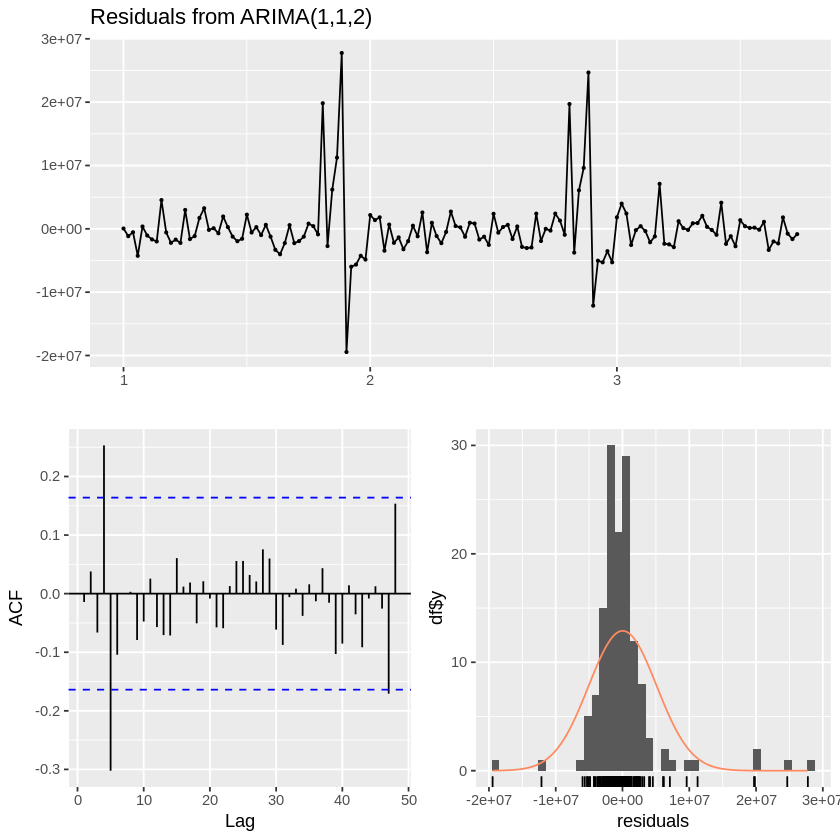

In [ ]:
# Fit both models
model_112 <- Arima(sales_ts, order = c(1,1,2))

# Compare AIC/BIC
AIC(model_112)
BIC(model_112)

# Check residuals
checkresiduals(model_112)

# Forecast and compare accuracy (optional)
accuracy(model_112)

In [ ]:
AIC(model_111, model_112)
BIC(model_111, model_112)

,df,AIC
,<dbl>,<dbl>
model_111,3,4800.892
model_112,4,4800.935


,df,BIC
,<dbl>,<dbl>
model_111,3,4809.759
model_112,4,4812.759


In [ ]:
# Auto ARIMA selects best (p,d,q) automatically
model <- auto.arima(sales_ts)

# View model
summary(model)


Series: sales_ts 
ARIMA(1,1,1)(0,1,0)[52] 

Coefficients:
         ar1      ma1
      0.1275  -0.9089
s.e.  0.1140   0.0418

sigma^2 = 3.434e+12:  log likelihood = -1426.35
AIC=2858.7   AICc=2858.97   BIC=2866.2

Training set error measures:
                   ME    RMSE      MAE       MPE    MAPE      MASE        ACF1
Training set 156222.8 1453726 820012.5 0.3389655 1.72022 0.5722561 0.006738708

**Residual Diagnostics**


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)(0,1,0)[52]
Q* = 19.845, df = 27, p-value = 0.8372

Model df: 2.   Total lags used: 29



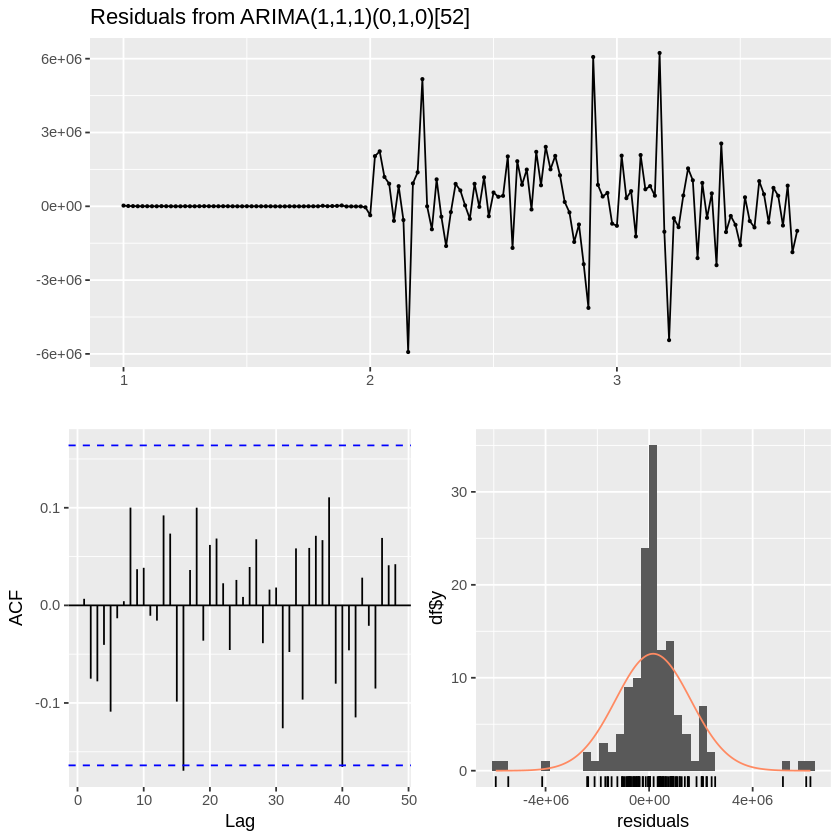

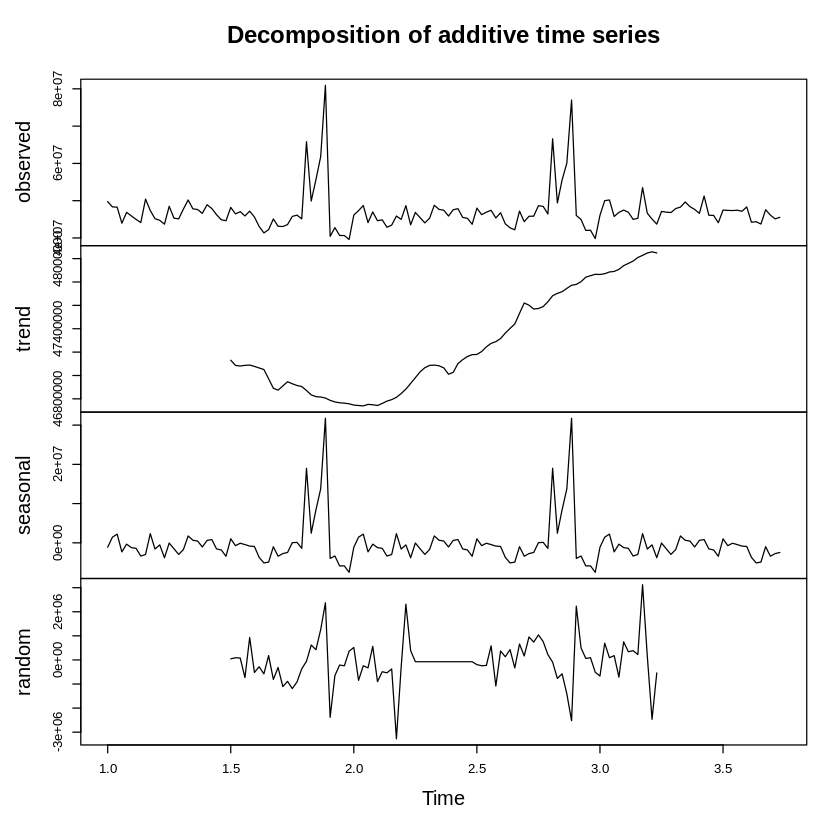

In [ ]:
# Check if residuals are white noise
checkresiduals(model)

# Decompose
decomp <- decompose(sales_ts)
plot(decomp)


**Corrplot**

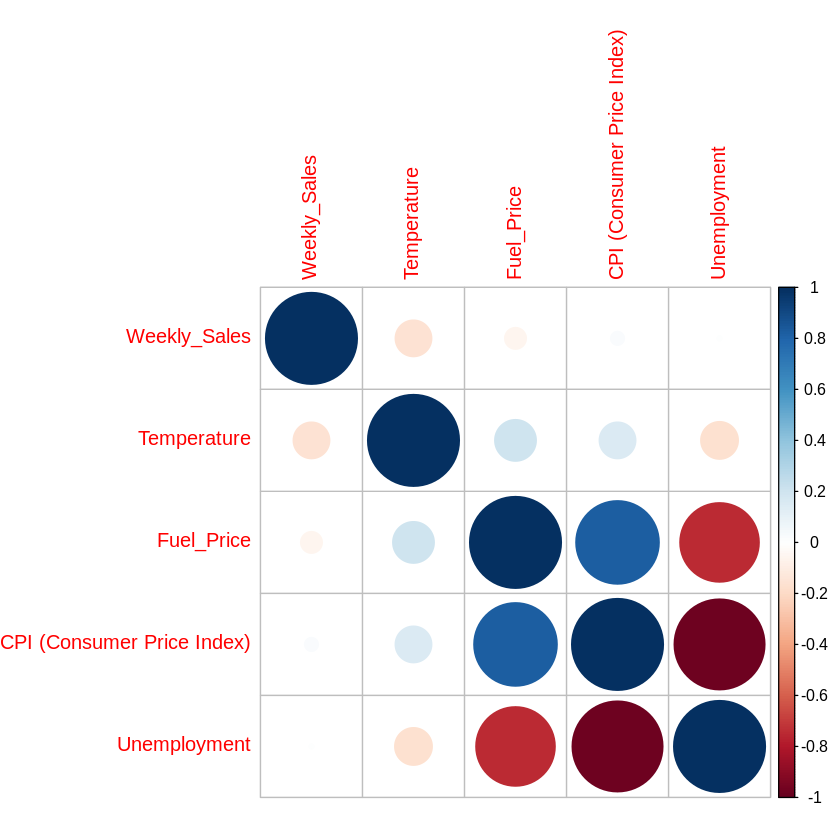

In [ ]:
# Step 1: Reload your dataset
library(readxl)
df <- read_excel("/content/walmart_sales_cleaned.xlsx")

# Step 2: Make sure Date is correct
library(lubridate)
df$Date <- dmy(df$Date)

# Step 3: Now create df_corr
library(dplyr)
df_corr <- df %>%
  group_by(Date) %>%
  summarise(across(c(Weekly_Sales, Temperature, Fuel_Price, `CPI (Consumer Price Index)`, Unemployment), mean, na.rm = TRUE))

# Now you can calculate correlation and plot
cor_matrix <- cor(df_corr[,-1])
library(corrplot)
corrplot(cor_matrix, method = "circle")


**Forecasting and Plotting**

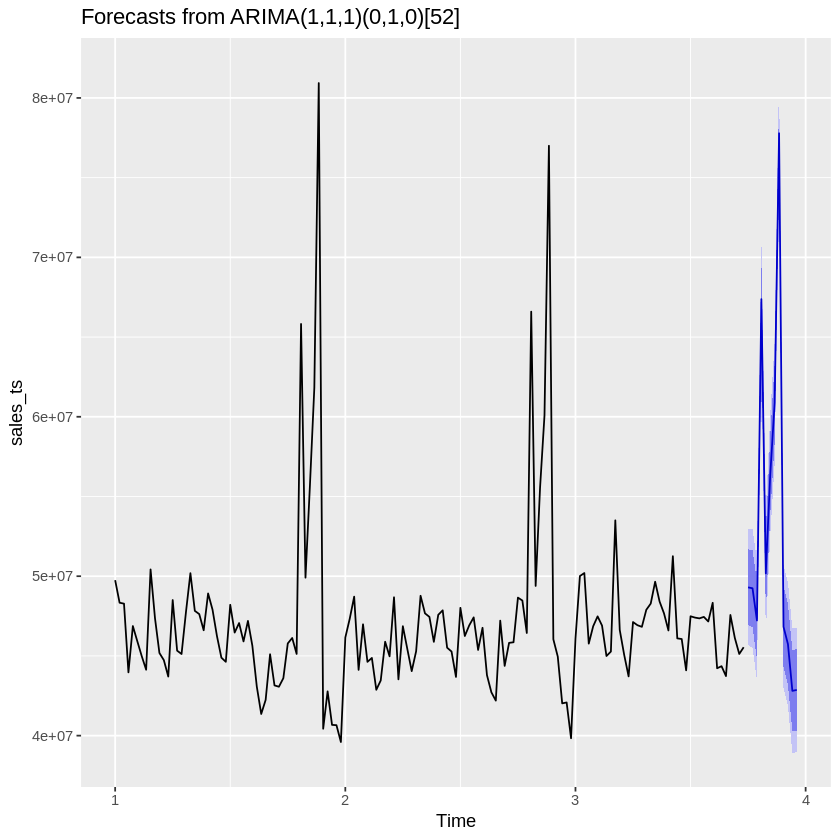

In [ ]:
# Forecast next 12 weeks
forecast_sales <- forecast(model, h = 12)
# Plot forecast
autoplot(forecast_sales)


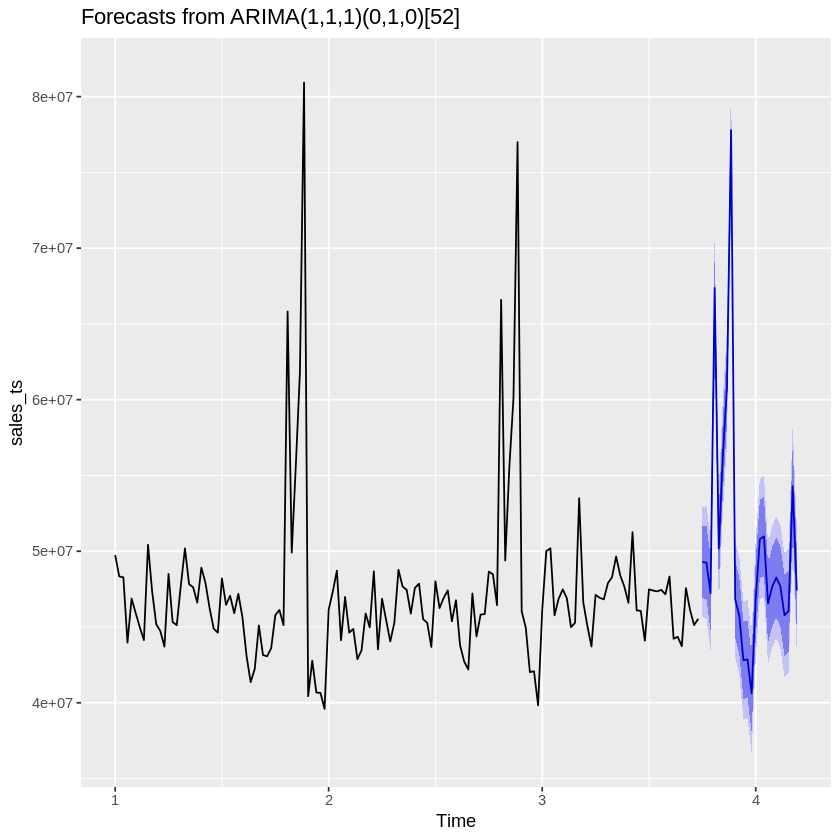

In [ ]:
forecast_sales <- forecast(model, h = 24)
autoplot(forecast_sales)


Model Evaluation Metrics

In [ ]:
# Accuracy metrics on training data
accuracy(model)


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,156222.8,1453726,820012.5,0.3389655,1.72022,0.5722561,0.006738708


#**All though it is enough which I did above but some other steps/things that we can do to get a some more insights**

**ARIMAX Modeling with External Regressors
We’ll add external variables like Holiday_Flag, Fuel_Price, Unemployment, or Temperature into an ARIMA model using xreg.**

In [ ]:
names(df_corr)


[1] "Date"                       "Weekly_Sales"              
[3] "Temperature"                "Fuel_Price"                
[5] "CPI (Consumer Price Index)" "Unemployment"

In [ ]:
df$Holiday_Flag <- ifelse(week(df$Date) == 48 & month(df$Date) == 11, 1, 0)


In [ ]:
df_corr <- df %>%
  group_by(Date) %>%
  summarise(
    Weekly_Sales = sum(Weekly_Sales, na.rm = TRUE),
    Temperature = mean(Temperature, na.rm = TRUE),
    Fuel_Price = mean(Fuel_Price, na.rm = TRUE),
    CPI = mean(`CPI (Consumer Price Index)`, na.rm = TRUE),
    Unemployment = mean(Unemployment, na.rm = TRUE),
    Holiday_Flag = max(Holiday_Flag, na.rm = TRUE)  # Use max if it's binary (0/1)
  )


In [ ]:
xreg_vars <- as.matrix(df_corr[, c("Holiday_Flag", "Fuel_Price", "Unemployment")])
model_arimax <- auto.arima(sales_ts, xreg = xreg_vars)
summary(model_arimax)

Series: sales_ts 
Regression with ARIMA(1,0,0)(0,1,0)[52] errors 

Coefficients:
         ar1      drift  Holiday_Flag  Fuel_Price  Unemployment
      0.1409  -63284.38      10562.83   1147210.3      -5423681
s.e.  0.1060   28254.06    1725762.75    968712.3       1766373

sigma^2 = 3.202e+12:  log likelihood = -1436.66
AIC=2885.32   AICc=2886.32   BIC=2900.38

Training set error measures:
                   ME    RMSE      MAE        MPE   MAPE      MASE       ACF1
Training set 35996.07 1387759 779511.2 0.07615898 1.6343 0.5439918 0.01200847

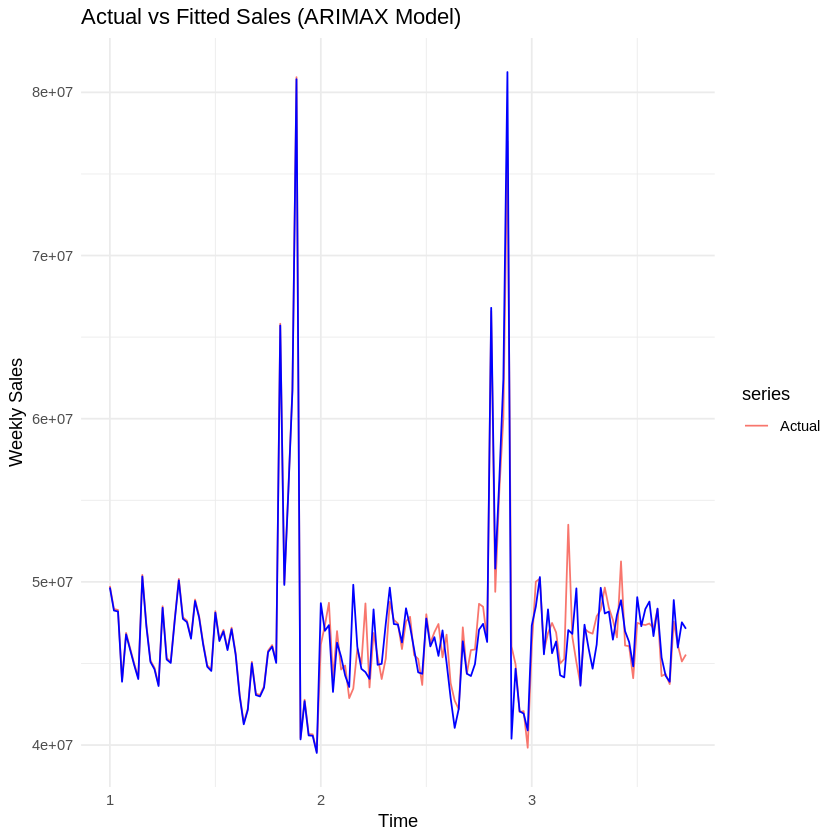

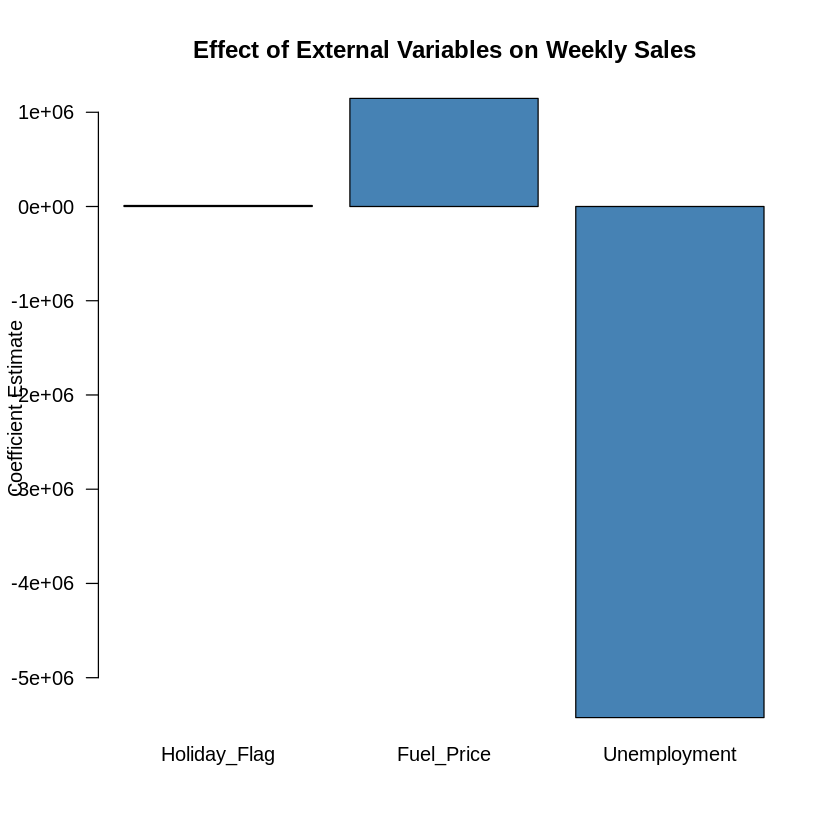


	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,0,0)(0,1,0)[52] errors
Q* = 21.441, df = 28, p-value = 0.8065

Model df: 1.   Total lags used: 29



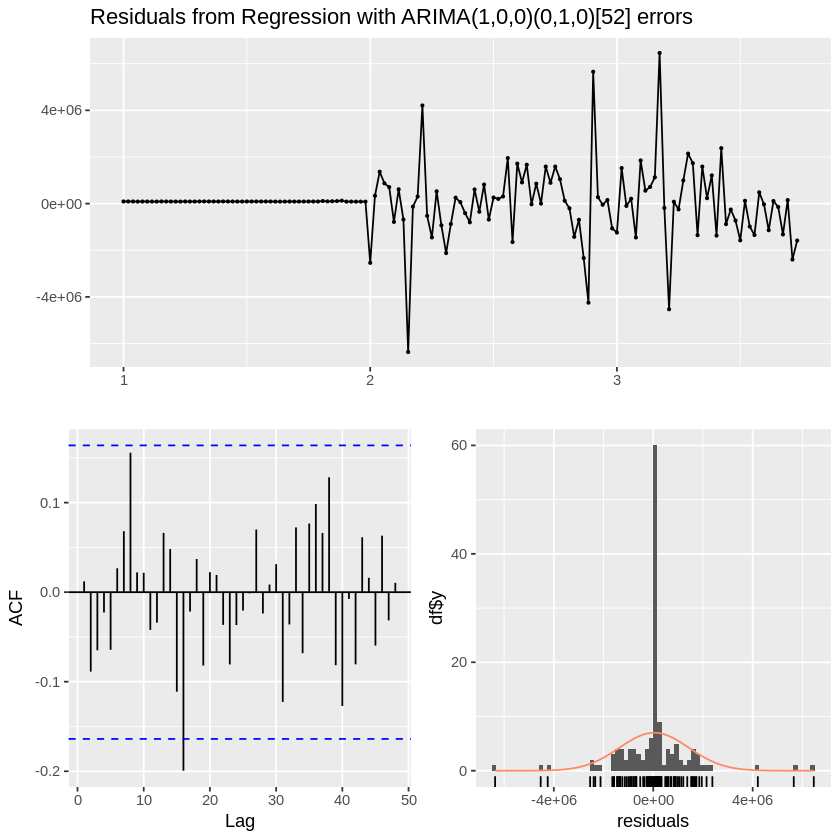

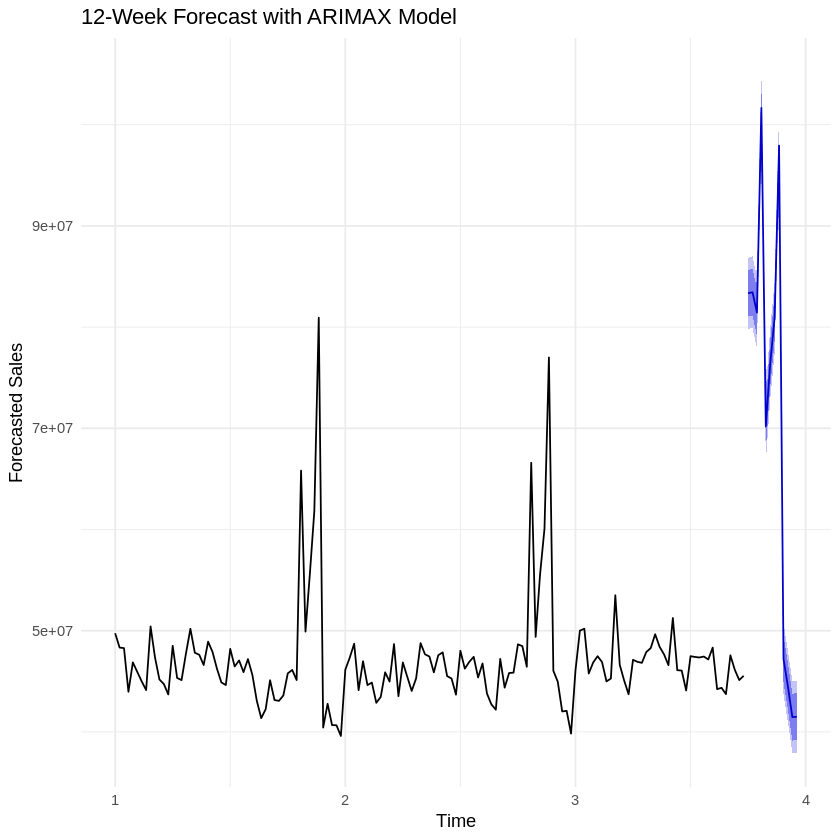

In [ ]:
# Load required libraries
library(forecast)
library(ggplot2)
library(lubridate)

# === 1. Actual vs Fitted Sales ===
fitted_values <- fitted(model_arimax)

autoplot(sales_ts, series = "Actual") +
  autolayer(fitted_values, series = "Fitted", color = "blue") +
  ggtitle("Actual vs Fitted Sales (ARIMAX Model)") +
  ylab("Weekly Sales") + xlab("Time") +
  theme_minimal()

# === 2. Bar Plot: Effect of External Variables ===
coefs <- coef(model_arimax)[c("Holiday_Flag", "Fuel_Price", "Unemployment")]

barplot(coefs,
        main = "Effect of External Variables on Weekly Sales",
        col = "steelblue",
        ylab = "Coefficient Estimate",
        las = 1)

# === 3. Residual Diagnostics ===
checkresiduals(model_arimax)

# === 4. Forecast (12 Weeks Ahead with Dummy xreg) ===
# Create dummy future data (adjust based on your context)
future_xreg <- matrix(rep(colMeans(xreg_vars), each = 12), ncol = 3, byrow = TRUE)
colnames(future_xreg) <- c("Holiday_Flag", "Fuel_Price", "Unemployment")

forecast_arimax <- forecast(model_arimax, xreg = future_xreg, h = 12)

autoplot(forecast_arimax) +
  ggtitle("12-Week Forecast with ARIMAX Model") +
  ylab("Forecasted Sales") + xlab("Time") +
  theme_minimal()


In [ ]:
start(sales_ts)
end(sales_ts)
frequency(sales_ts)


[1] 1 1

[1]  3 39

[1] 52

In [ ]:
train <- window(sales_ts, end = c(3, 30))  # adjust this safely within range
test  <- window(sales_ts, start = c(3, 31))


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Test set,-1693557,2167581,1791194,-3.672829,3.868869,1.178552,-0.05982967,1.053075


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Training set,239050.6,1431227,727366.7,0.5273241,1.511868,0.4785856,-0.01068596,NA


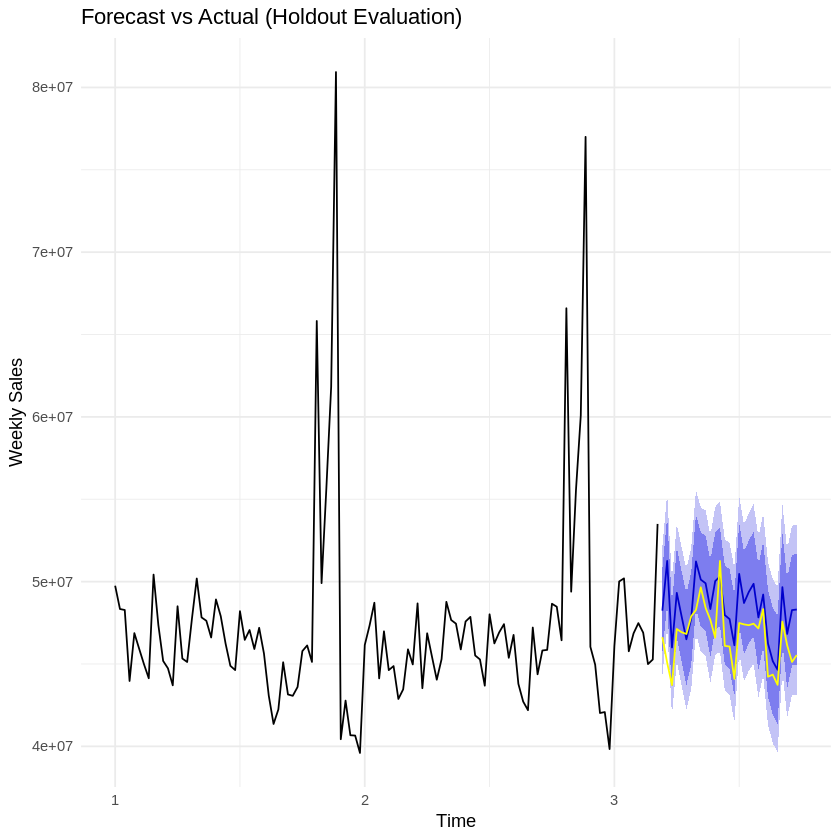

In [ ]:
# Load necessary libraries
library(forecast)
library(ggplot2)

# Step 1: Length of full series
n <- length(sales_ts)

# Step 2: Define 80/20 split
split_point <- floor(n * 0.8)

# Step 3: Split into training and test sets
train <- ts(sales_ts[1:split_point], frequency = 52)

# Set test to begin right after training ends
test_start <- time(sales_ts)[split_point + 1]
test <- ts(sales_ts[(split_point + 1):n], start = test_start, frequency = 52)

# Step 4: Fit ARIMA model to training data
model_holdout <- auto.arima(train)

# Step 5: Forecast using the model
forecast_holdout <- forecast(model_holdout, h = length(test))

# Step 6: Plot forecast vs actual
autoplot(forecast_holdout) +
  autolayer(test, series = "Actual", color = "yellow") +
  ggtitle("Forecast vs Actual (Holdout Evaluation)") +
  ylab("Weekly Sales") + xlab("Time") +
  theme_minimal()
#convert to a data frame for saving or further use
accuracy_metrics <- accuracy(forecast_holdout, test)
accuracy_df <- as.data.frame(accuracy_metrics)

# View just the Test set or Training set
accuracy_df["Test set", ]     # To view only test set metrics
accuracy_df["Training set", ] # To view only training set metrics




Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


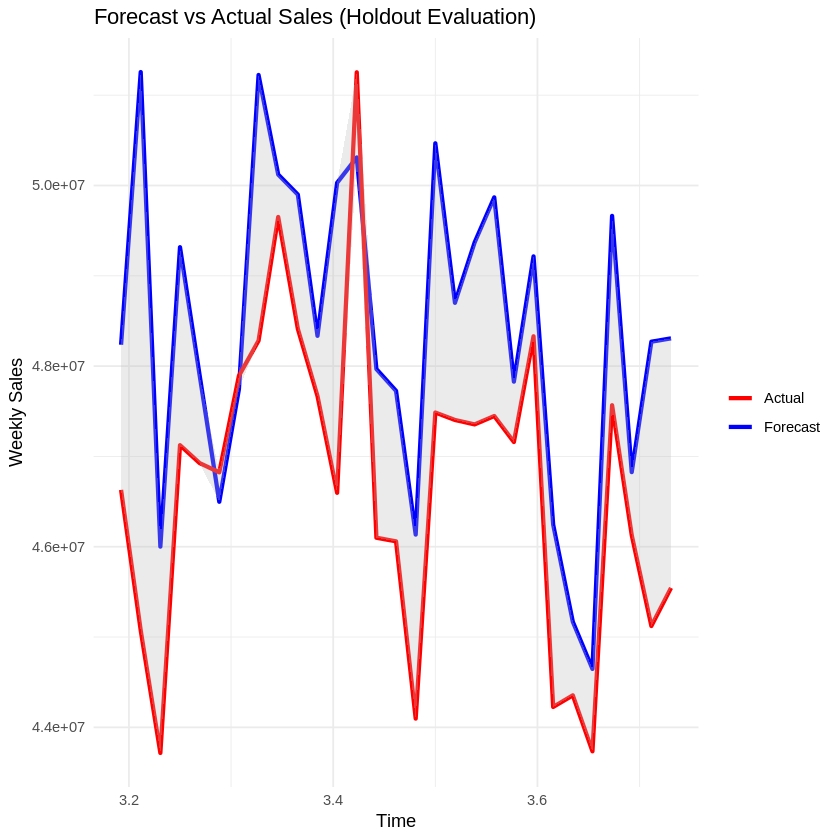

In [ ]:
library(ggplot2)

# Create data frame from forecast and actual
df_plot <- data.frame(
  Week = time(test),
  Forecast = as.numeric(forecast_holdout$mean),
  Actual = as.numeric(test)
)

# Plot with shaded difference
ggplot(df_plot, aes(x = Week)) +
  geom_line(aes(y = Forecast, color = "Forecast"), size = 1.2) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1.2) +
  geom_ribbon(aes(ymin = pmin(Forecast, Actual),
                  ymax = pmax(Forecast, Actual)),
              fill = "gray", alpha = 0.3) +
  scale_color_manual(values = c("Forecast" = "blue", "Actual" = "red")) +
  ggtitle("Forecast vs Actual Sales (Holdout Evaluation)") +
  xlab("Time") + ylab("Weekly Sales") +
  theme_minimal() +
  theme(legend.title = element_blank())


#**Hold ARIMAX**

In [ ]:
# Extract the same columns you used in training (same order)
xreg_test <- as.matrix(df_corr[(split_point + 1):n, c("Holiday_Flag", "Fuel_Price", "Unemployment")])


In [ ]:
forecast_arimax <- forecast(model_arimax, xreg = xreg_test, h = length(test))


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Training set,48883.63,1366411,716779.2,0.124985,1.489239,0.4716194,0.1123131,NA
Test set,-755622.67,1677013,1382264.6,-1.677441,2.974008,0.9094890,0.1604276,0.8231462


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


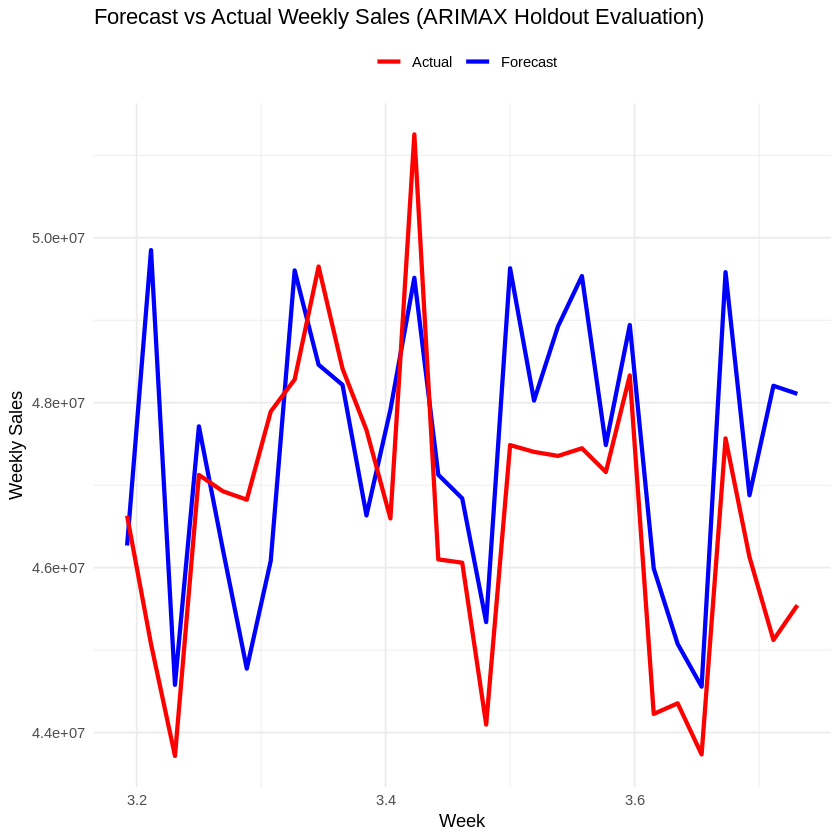

In [ ]:
# Step 1: Get accuracy metrics for both training and test
accuracy_arimax <- accuracy(forecast_arimax, test)

# Step 2: Convert to data frame (this will show exactly like your image)
accuracy_df <- as.data.frame(accuracy_arimax)

# Step 3: View the result in spreadsheet-style (exact as your screenshot)
View(accuracy_df)


df_arimax <- data.frame(
  Week = time(test),
  Forecast = as.numeric(forecast_arimax$mean),
  Actual = as.numeric(test)
)

ggplot(df_arimax, aes(x = Week)) +
  geom_line(aes(y = Forecast, color = "Forecast"), size = 1.2) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1.2) +
  scale_color_manual(values = c("Forecast" = "blue", "Actual" = "red")) +
  labs(title = "Forecast vs Actual Weekly Sales (ARIMAX Holdout Evaluation)",
       x = "Week", y = "Weekly Sales", color = "") +
  theme_minimal() +
  theme(legend.position = "top")
